In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import time

import matplotlib.pyplot as plt

import scipy
from scipy import linalg

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from WrapScalableSVM import *
from Utils_SSVM import *
from utilsData import *
from modelEvaluation import *
from utilsPlot import *

import joblib

# Tests for the xAI-2024 conference paper
# Load datasets

In [2]:
datapath = "simulationVictorTopological/"
train = "train.csv"
test = "test.csv"
cal = "calib.csv"

In [3]:
dbtrain = pd.read_csv(datapath+train)
dbtest = pd.read_csv(datapath+test)
dbcal = pd.read_csv(datapath+cal)
dbtrain

,SafetyMargin,Eta,Tau,meanEntropy,medianEntropy,stdsEntropy,iqrsEntropy,output
0,0.050213,0.028093,0.821334,2.665939,2.66510,0.035006,0.048525,33
1,0.084570,0.730420,0.351073,2.708023,2.70895,0.030586,0.037725,0
2,0.091477,0.488247,0.621771,2.700143,2.69890,0.025645,0.039050,0
3,0.030697,0.381998,0.323902,2.666678,2.66740,0.032531,0.049425,0
4,0.052030,0.851686,0.805093,2.678745,2.68140,0.025272,0.032500,0
...,...,...,...,...,...,...,...,...
3995,0.030611,0.540525,0.699096,2.661755,2.66450,0.034275,0.047125,7
3996,0.095805,0.245673,0.498006,2.713631,2.71250,0.023608,0.029850,0
3997,0.043050,0.451147,0.656740,2.670224,2.66920,0.024104,0.036625,0
3998,0.067698,0.822728,0.523789,2.687026,2.68800,0.020721,0.026425,0


Separate features and labels, and convert label 0 with 1 and 1 with -1

In [21]:
Xtr = dbtrain[['SafetyMargin', 'Eta', 'Tau','meanEntropy', 'medianEntropy', 'stdsEntropy', 'iqrsEntropy']].values
Ytr = dbtrain[['output']].values
Ytr[Ytr>1] = -1
Ytr[Ytr==0] = 1

Xts = dbtest[['SafetyMargin', 'Eta', 'Tau','meanEntropy', 'medianEntropy', 'stdsEntropy', 'iqrsEntropy']].values
Yts = dbtest[['output']].values
Yts[Yts>1] = -1
Yts[Yts==0] = 1

Xcal = dbcal[['SafetyMargin', 'Eta', 'Tau','meanEntropy', 'medianEntropy', 'stdsEntropy', 'iqrsEntropy']].values
Ycal = dbcal[['output']].values
Ycal[Ycal>1] = -1
Ycal[Ycal==0] = 1

# Exploratory analisis

In [4]:
correlation_matrix = dbtrain.corr()
print(correlation_matrix)

dbtrain['outputTrans'] = dbtrain['output'].apply(lambda x: 1 if x > 0 else -1)
dbtrain

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
               SafetyMargin       Eta       Tau  meanEntropy  medianEntropy  \
SafetyMargin       1.000000  0.017253  0.000908     0.905927       0.903826   
Eta                0.017253  1.000000 -0.021480     0.098178       0.097438   
Tau                0.000908 -0.021480  1.000000    -0.287795      -0.290273   
meanEntropy        0.905927  0.098178 -0.287795     1.000000       0.995989   
medianEntropy      0.903826  0.097438 -0.290273     0.995989       1.000000   
stdsEntropy       -0.632177 -0.114891 -0.030361    -0.616004      -0.614434   
iqrsEntropy       -0.558748 -0.109673 -0.077803    -0.534125      -0.531885   
output            -0.537112 -0.171379  0.321139    -0.631107      -0.633484   

               stdsEntropy  iqrsEntropy    output  
SafetyMargin     -0.632177    -0.558748 -0.537112  
Eta              -0.114891    

,SafetyMargin,Eta,Tau,meanEntropy,medianEntropy,stdsEntropy,iqrsEntropy,output,outputTrans
0,0.050213,0.028093,0.821334,2.665939,2.66510,0.035006,0.048525,33,1
1,0.084570,0.730420,0.351073,2.708023,2.70895,0.030586,0.037725,0,-1
2,0.091477,0.488247,0.621771,2.700143,2.69890,0.025645,0.039050,0,-1
3,0.030697,0.381998,0.323902,2.666678,2.66740,0.032531,0.049425,0,-1
4,0.052030,0.851686,0.805093,2.678745,2.68140,0.025272,0.032500,0,-1
...,...,...,...,...,...,...,...,...,...
3995,0.030611,0.540525,0.699096,2.661755,2.66450,0.034275,0.047125,7,1
3996,0.095805,0.245673,0.498006,2.713631,2.71250,0.023608,0.029850,0,-1
3997,0.043050,0.451147,0.656740,2.670224,2.66920,0.024104,0.036625,0,-1
3998,0.067698,0.822728,0.523789,2.687026,2.68800,0.020721,0.026425,0,-1


## Dispersion plots

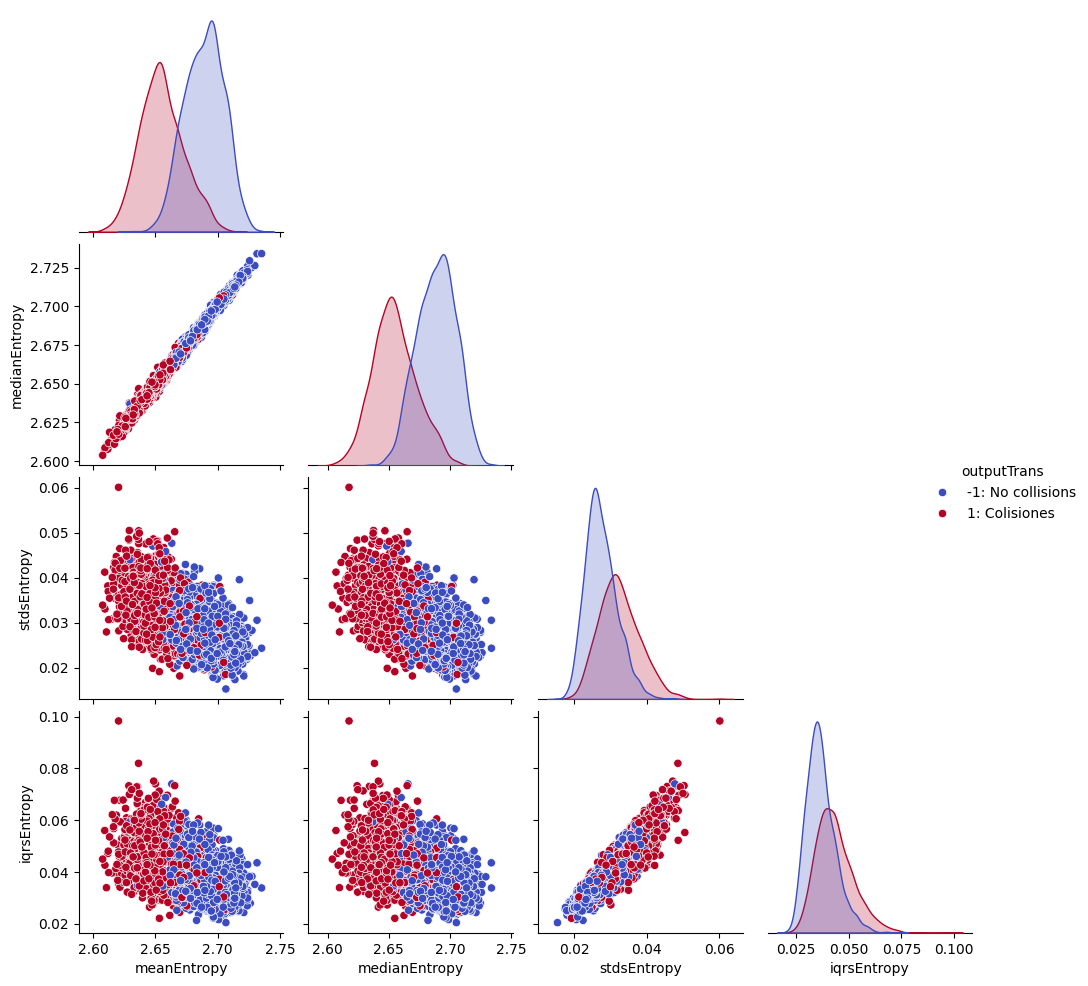

In [7]:
pairplot = sns.pairplot(dbtrain, vars=['meanEntropy', 'medianEntropy', 'stdsEntropy', 'iqrsEntropy'], hue='outputTrans', palette='coolwarm',corner=True)
new_labels = ['-1: No collisions', '1: Colisiones']  # Nombres personalizados
for t, label in zip(pairplot._legend.texts, new_labels):
    t.set_text(label)
plt.show()

## Boxplots

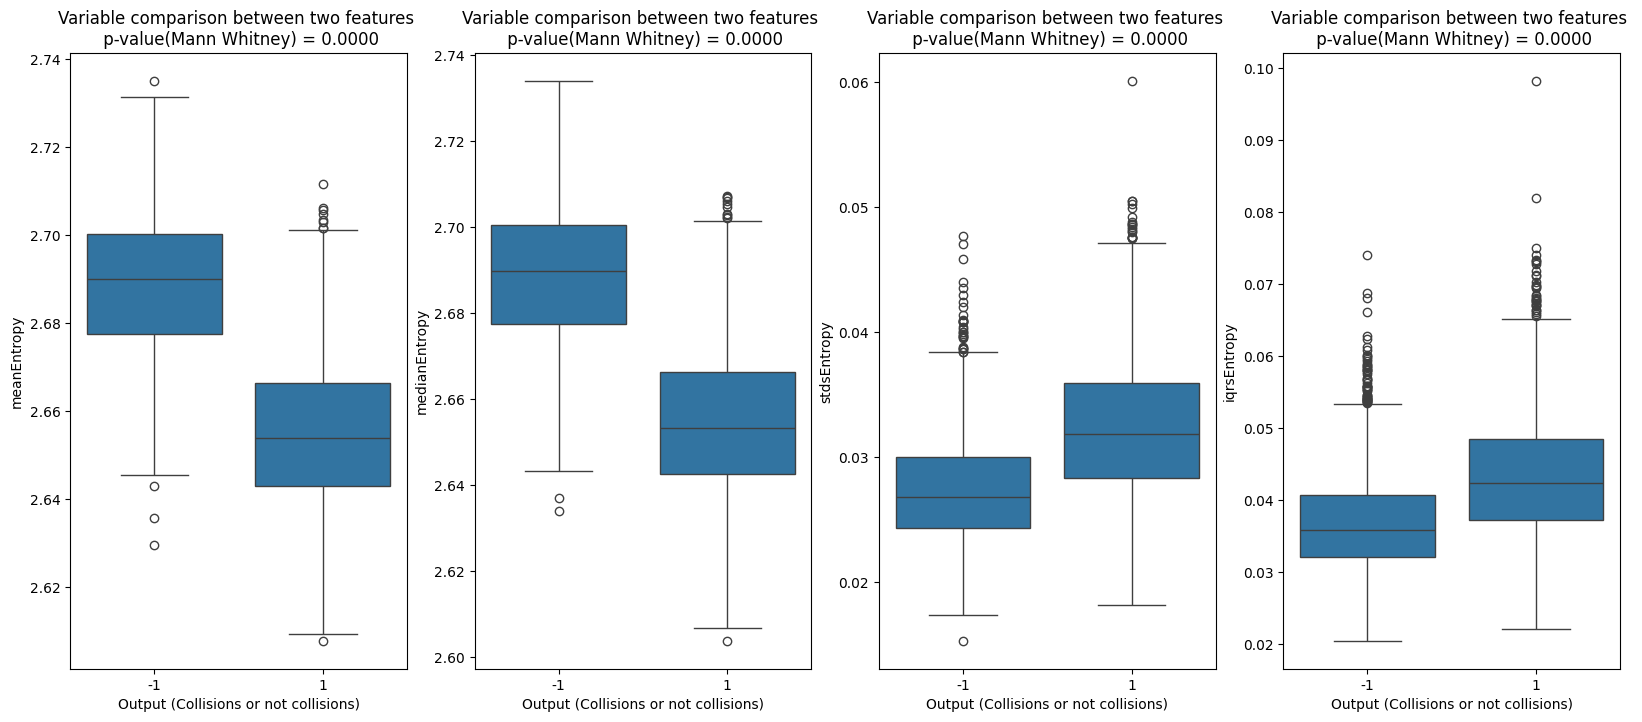

In [16]:
from scipy.stats import mannwhitneyu
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 8))
axes = axes.flatten()
for num,i in enumerate(['meanEntropy', 'medianEntropy', 'stdsEntropy', 'iqrsEntropy']):
    Cvalues = dbtrain[dbtrain["outputTrans"] == 1][i].values
    NCvalues = dbtrain[dbtrain["outputTrans"] == -1][i].values
    u_stat, p_value = mannwhitneyu(Cvalues, NCvalues, alternative="two-sided")
    plt.sca(axes[num])
    sns.boxplot(x='outputTrans', y=i, data=dbtrain)
    plt.title(f'Variable comparison between two features \n p-value(Mann Whitney) = {p_value:.4f}')
    plt.xlabel("Output (Collisions or not collisions)")
    plt.ylabel(i)

plt.show()

# SVM parameters setting

In [17]:
# Parameters settings
kernel = "gaussian" #with gaussian work, with polynomial no.
param = 0.5 # play with this to improve model evaluation, explaination on chatgpt
tau = np.array([[0.5]])
eta = 0.3

# Scaling setting

In [18]:
epsilon = 0.1

In [19]:
# si quieres normalizar
# XtrScaled = scaler.fit_transform(Xtr)
# XcalScaled = scaler.fit_transform(Xcal)
# XtsScaled = scaler.fit_transform(Xts)

In [26]:
Xtr[:,-3:].shape

(4000, 3)

## 1) Classic SVM

In [27]:
start_time = time.time()

model = ScalableSVMClassifier(eta, kernel, param, tau)

model = model.fit(Xtr[:,-4:],Ytr) #[:,-4:] solo caract topol
joblib.dump(model, datapath+"classicSVM_safeEff.sav")
end_time = time.time()

elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time} seconds")

Elapsed time: 78.86037254333496 seconds


In [28]:
model = model.FPcontrol(Xcal[:,-4:], Ycal, epsilon,'classic')
model.get_params()

{'alpha': array([ 4.99872383e-01, -2.30312013e-05, -7.37558808e-06, ...,
         5.00093371e-01,  5.00015073e-01, -1.54270367e-05]),
 'b': array([0.01518191]),
 'b_eps': 0,
 'eta': 0.3,
 'kernel': 'gaussian',
 'param': 0.5,
 'tau': array([[0.5]]),
 'solver': 'osqp'}

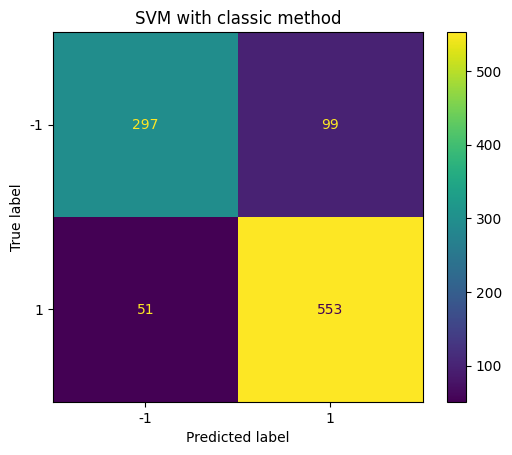

ACC = 0.85, F1 = 0.8805732484076433, PPV = 0.848159509202454, NPV = 0.853448275862069, TPR = 0.9155629139072847, TNR = 0.75, FPR = 0.25, FNR = 0.08443708609271523

TP = 553, FP = 99, TN = 297, FN = 51


In [29]:
metricsClassic = EvaluateModel(model, Xts[:,-4:], Yts, f"SVM with {model.method} method")


In [30]:
joblib.dump(model,datapath+"Classic_SVM_safe.sav")

['simulationVictorTopological/Classic_SVM_safe.sav']

## 2) Probabilistic Safety Region

In [33]:
model = model.FPcontrol(Xcal[:,-4:], Ycal, epsilon,'ps')
model.get_params()

{'alpha': array([ 4.99872383e-01, -2.30312013e-05, -7.37558808e-06, ...,
         5.00093371e-01,  5.00015073e-01, -1.54270367e-05]),
 'b': array([0.01518191]),
 'b_eps': 0.42340711216246857,
 'eta': 0.3,
 'kernel': 'gaussian',
 'param': 0.5,
 'tau': array([[0.5]]),
 'solver': 'osqp'}

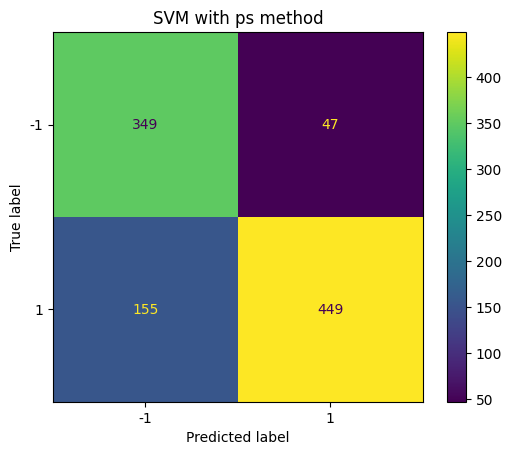

ACC = 0.798, F1 = 0.8163636363636364, PPV = 0.905241935483871, NPV = 0.6924603174603174, TPR = 0.7433774834437086, TNR = 0.8813131313131313, FPR = 0.11868686868686869, FNR = 0.25662251655629137

TP = 449, FP = 47, TN = 349, FN = 155


In [35]:
metricsPSR = EvaluateModel(model, Xts[:,-4:], Yts, f"SVM with {model.method} method")

In [36]:
joblib.dump(model,datapath+"PS_SVM_safe.sav")

['simulationVictorTopological/PS_SVM_safe.sav']

In [41]:
# save to file
y_ps_tr = model.predict(Xtr[:,-4:]).reshape((len(Xtr),1))
y_ps_cal = model.predict(Xcal[:,-4:]).reshape((len(Xcal),1))
y_ps_ts = model.predict(Xts[:,-4:]).reshape((len(Xts),1))

train = pd.DataFrame(np.hstack((Xtr[:,-4:],Ytr,y_ps_tr)), columns = ['meanEntropy', 'medianEntropy', 'stdsEntropy', 'iqrsEntropy',"y_true","y_conformal"])
calib = pd.DataFrame(np.hstack((Xcal[:,-4:],Ycal,y_ps_cal)), columns = ['meanEntropy', 'medianEntropy', 'stdsEntropy', 'iqrsEntropy',"y_true","y_conformal"])
test = pd.DataFrame(np.hstack((Xts[:,-4:],Yts,y_ps_ts)), columns = ['meanEntropy', 'medianEntropy', 'stdsEntropy', 'iqrsEntropy',"y_true","y_conformal"])
train.to_csv(datapath+"train_ps.csv", index = False)
calib.to_csv(datapath+"calib_ps.csv", index = False)
test.to_csv(datapath+"test_ps.csv", index = False)

# 3) Conformal Safety Regions


In [37]:
model = model.FPcontrol(Xcal[:,-4:], Ycal, 0.1,'cp')
model.get_params()

{'alpha': array([ 4.99872383e-01, -2.30312013e-05, -7.37558808e-06, ...,
         5.00093371e-01,  5.00015073e-01, -1.54270367e-05]),
 'b': array([0.01518191]),
 'b_eps': 0.21313178659477316,
 'eta': 0.3,
 'kernel': 'gaussian',
 'param': 0.5,
 'tau': array([[0.5]]),
 'solver': 'osqp'}

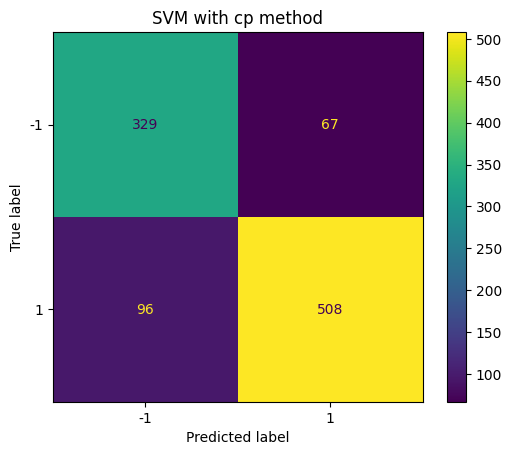

ACC = 0.837, F1 = 0.8617472434266328, PPV = 0.8834782608695653, NPV = 0.7741176470588236, TPR = 0.8410596026490066, TNR = 0.8308080808080808, FPR = 0.1691919191919192, FNR = 0.15894039735099338

TP = 508, FP = 67, TN = 329, FN = 96


In [38]:
metricsCSR = EvaluateModel(model, Xts[:,-4:], Yts, f"SVM with {model.method} method")

In [39]:
joblib.dump(model,datapath+"CP_SVM_safe.sav")

['simulationVictorTopological/CP_SVM_safe.sav']

In [43]:
# save to file
y_ps_tr = model.predict(Xtr[:,-4:]).reshape((len(Xtr),1))
y_ps_cal = model.predict(Xcal[:,-4:]).reshape((len(Xcal),1))
y_ps_ts = model.predict(Xts[:,-4:]).reshape((len(Xts),1))

train = pd.DataFrame(np.hstack((Xtr[:,-4:],Ytr,y_ps_tr)), columns = ['meanEntropy', 'medianEntropy', 'stdsEntropy', 'iqrsEntropy',"y_true","y_conformal"])
calib = pd.DataFrame(np.hstack((Xcal[:,-4:],Ycal,y_ps_cal)), columns = ['meanEntropy', 'medianEntropy', 'stdsEntropy', 'iqrsEntropy',"y_true","y_conformal"])
test = pd.DataFrame(np.hstack((Xts[:,-4:],Yts,y_ps_ts)), columns = ['meanEntropy', 'medianEntropy', 'stdsEntropy', 'iqrsEntropy',"y_true","y_conformal"])
train.to_csv(datapath+"train_cp.csv", index = False)
calib.to_csv(datapath+"calib_cp.csv", index = False)
test.to_csv(datapath+"test_cp.csv", index = False)